In [ ]:
# Importar librerías
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, accuracy_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Practica/datasets/datasets-main/House Prices - Advanced Regression Techniques/House_Prices_Advanced_Cleaned.csv")

In [ ]:
df= data.copy()

In [ ]:
df.info()

In [ ]:
# Revisar valores faltantes
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


# Preprocesamiento de Datos



In [ ]:
# Seleccionar solo las columnas numéricas
X = df.select_dtypes(include=['float64', 'int64'])
X1 = preprocessing.normalize(X)


# Análisis Exploratorio de Datos (EDA)
Para entender la distribución de los datos y detectar patrones

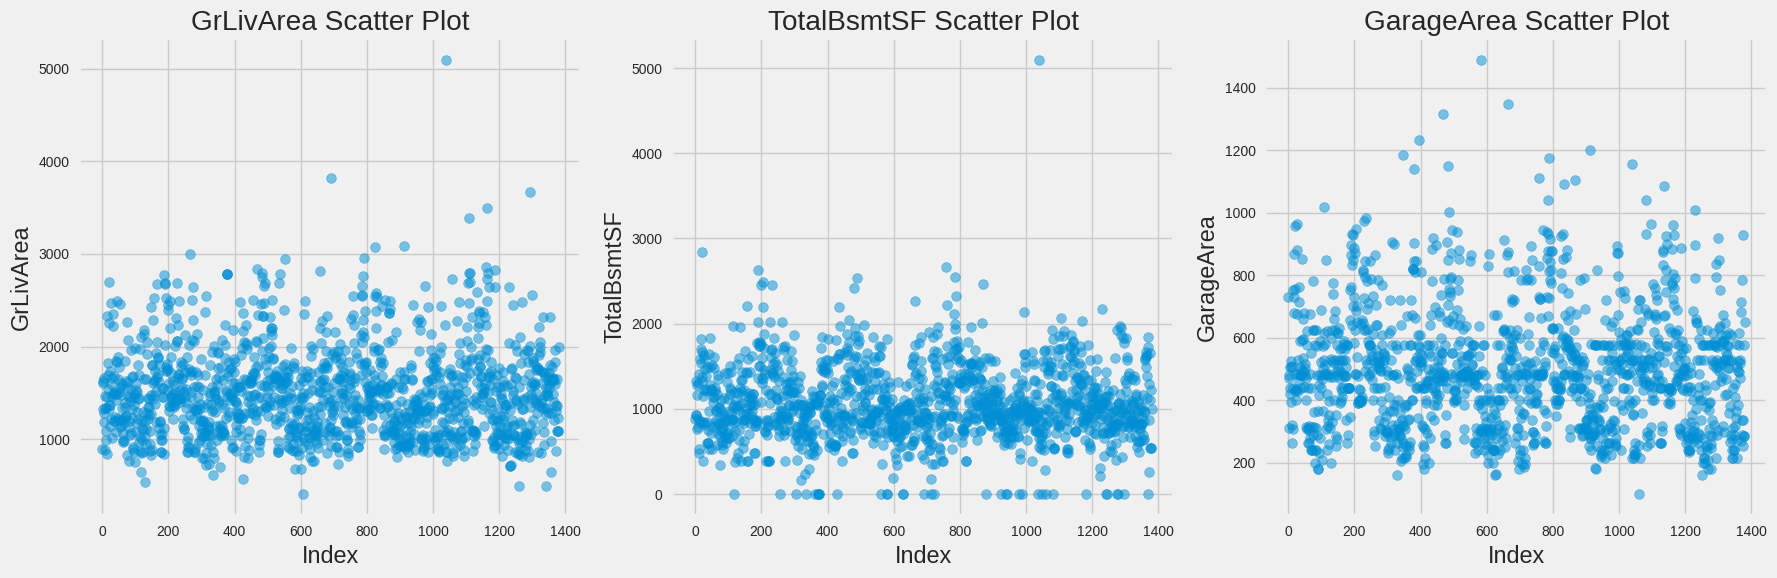

In [ ]:
# Seleccionar las variables para visualizar su dispersion utilizando estilo de FivrThirtyEight
variables = ['GrLivArea', 'TotalBsmtSF', 'GarageArea']

# Establecer el estilo de fivethirtyeight
plt.style.use('fivethirtyeight')

# Crear la figura y los ejes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Graficar cada variable en un scatter plot
for ax, var in zip(axes, variables):
    ax.scatter(df.index, df[var], alpha=0.5)
    ax.set_title(f'{var} Scatter Plot')
    ax.set_xlabel('Index')
    ax.set_ylabel(var)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Técnicas de Aprendizaje No Supervisado (KMeans)
Aplicando técnicas de clustering para identificar patrones en los datos sin etiquetas

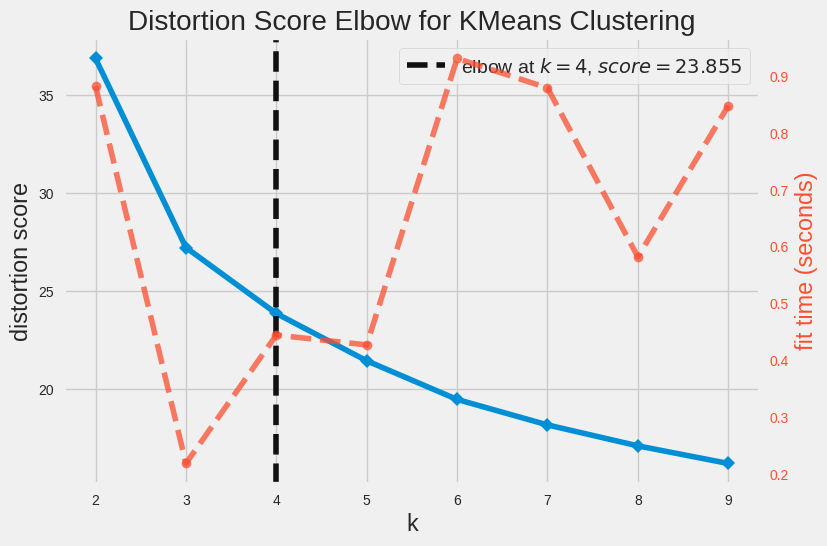

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Inicializar el modelo KMeans
model = KMeans(n_init=10)

# Inicializar el visualizador Kelbow
visualizer = KElbowVisualizer(model, k=(2, 10))  # Define el rango de k que deseas explorar

# Ajustar el visualizador al dataframe normalizado
visualizer.fit(X1)

# Mostrar el gráfico
visualizer.show()

In [ ]:
kmedia_4 = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300,
tol=0.0001, random_state=111, algorithm='elkan')

kmedia_4.fit(X1)
labels_4 = kmedia_4.labels_           # Etiquetar los clusters
centroides=kmedia_4.cluster_centers_   # Centroides de cada uno de los cuatro clusters

df['clusters_4']=labels_4

In [ ]:
fix=px.scatter_3d(df,x='GrLivArea',y='TotalBsmtSF', z='GarageArea', color='clusters_4', width=800, height=800)
fix.show()

# Análisis de Componentes Principales (PCA)
Crear una Visualización de los componentes principales para conocer cómo se agrupan los datos en el espacio reducido.

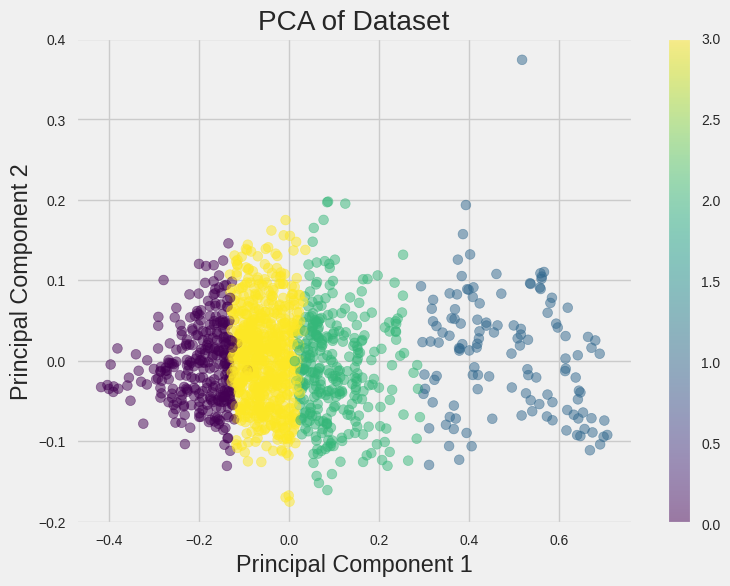

In [ ]:
# Normalizar las características antes de aplicar PCA
X_normalized = preprocessing.normalize(X)

# Aplicar PCA
pca = PCA(n_components=2)  # Reduce a 2 componentes principales para visualización
principal_components = pca.fit_transform(X_normalized)

# Visualizar los componentes principales
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels_4, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.colorbar()
plt.show()


# Verificar si hay desbalance de clases

SaleCondition
Normal     1148
Partial     118
Abnorml      75
Family       25
Alloca       10
AdjLand       5
Name: count, dtype: int64


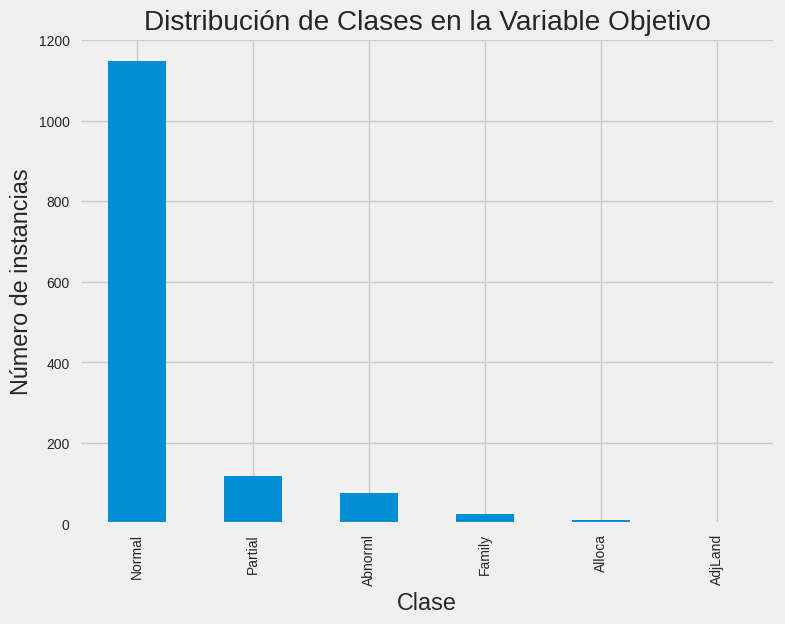

In [ ]:
# Primero, veamos la distribución de clases en el dataset original
class_distribution = df['SaleCondition'].value_counts()

# Imprimir la distribución de clases
print(class_distribution)

# Graficar la distribución de clases
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.title('Distribución de Clases en la Variable Objetivo')
plt.show()

# Generación de Datos Sintéticos
Usando una técnica llamada SMOTE (Synthetic Minority Over-sampling Technique) para generar instancias sintéticas de la clase minoritaria ya que encontramos un desbalance en las clases.

In [ ]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar las características y la variable objetivo
X = df_encoded.drop(columns='SaleCondition_Partial')
y = df_encoded['SaleCondition_Partial']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar la nueva distribución de clases
print(y_train_smote.value_counts())

SaleCondition_Partial
False    1014
True     1014
Name: count, dtype: int64


# Preparación de Datos para Modelos Supervisados
Convertir las variables categóricas a numéricas y dividir los datos en conjuntos de entrenamiento y prueba

In [ ]:
# Separar las características y la variable objetivo
X = df_encoded.drop(columns='SaleCondition_Partial')
y = df_encoded['SaleCondition_Partial']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando Técnicas de Aprendizaje Supervisado (Random Forest)
Entrenando y evaluando el modelo supervisado para predecir la variable objetivo.

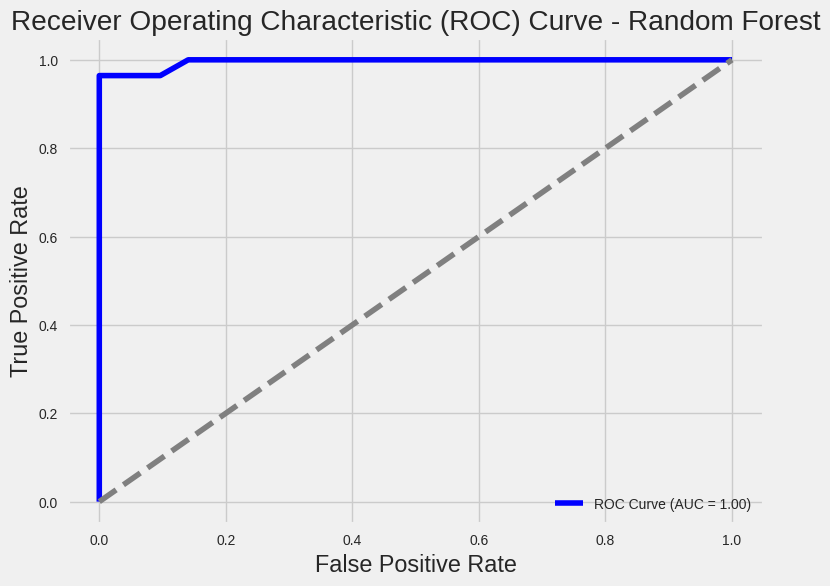

In [ ]:
# Crear el modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo en todo el conjunto de entrenamiento
model_rf.fit(X_train, y_train)

# Predecir las probabilidades en el conjunto de prueba
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Validación Cruzada
Aplicamos validación cruzada para evaluar la estabilidad y generalización del modelo.

In [ ]:
# Entrenar el modelo de Regresión Logística y aplicar K-Fold Cross Validation

# Normalizar las características
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)


**Creación y Evaluación del Modelo de Random Forest**
Se creó un modelo de Random Forest.
Se aplicó K-Fold Cross Validation con 5 pliegues y se calculó el Área Bajo la Curva ROC (AUC) para cada pliegue.

In [ ]:
# Aplicar K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores_rf = cross_val_score(model_rf, X_train, y_train, cv=kf, scoring='roc_auc')

# Imprimir la media y desviación estándar de las puntuaciones AUC
print(f"Cross-Validation AUC Scores: {cross_val_scores_rf}")
print(f"Mean AUC: {np.mean(cross_val_scores_rf)}")
print(f"Standard Deviation AUC: {np.std(cross_val_scores_rf)}")

# También puedes imprimir la precisión del modelo
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

Cross-Validation AUC Scores: [0.99275362 1.         1.         1.         1.        ]
Mean AUC: 0.9985507246376812
Standard Deviation AUC: 0.0028985507246376495
Accuracy: 0.9963898916967509


**Creación y Evaluación del Modelo de Regresión Logística**
Se creó un modelo de Regresión Logística.
Se aplicó K-Fold Cross Validation con 5 pliegues y se calculó el Área Bajo la Curva ROC (AUC) para cada pliegue.

In [ ]:
# Crear el modelo de Regresión Logística
model = LogisticRegression()

# Aplicar K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_norm, y_train, cv=kf, scoring='roc_auc')

# Imprimir la media y desviación estándar de las puntuaciones AUC
print(f"Cross-Validation AUC Scores: {cross_val_scores}")
print(f"Mean AUC: {np.mean(cross_val_scores)}")
print(f"Standard Deviation AUC: {np.std(cross_val_scores)}")

Cross-Validation AUC Scores: [0.76363009 0.76666667 0.75490196 0.78809524 0.79982344]
Mean AUC: 0.774623478759561
Standard Deviation AUC: 0.016671112769270528
